# Autoencoder

An autoencoder basically consists on compressing the data in one part of the neural network and decompress it in a second part. The idea is that one person has the trained encoder and another the trained autoencoder and the former sends compress information to the latter. The latter is able to recompose part of the image (while adding some noise because of the compression).

This autoencoder will consist on 2 layers for the encoder and two more layers for the decoder. Both will have the same number of nodes.

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
#create tmp folder if does not exist
if not os.path.isdir('./tmp'):
    os.mkdir('./tmp')

# Download the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST/MNIST_data/", one_hot=True)

Extracting ../MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def get_batches(X,Y,batch_size):
    '''
    Get batches of data, input is features,target
    and batch_size, output is one minibatch
    '''
    iters = X.shape[0]//batch_size
    for i in range(0,iters):
        yield X[i*batch_size:(i+1)*batch_size],Y[i*batch_size:(i+1)*batch_size]

In [3]:
# Training Parameters
learning_rate = 0.01
epochs = 150
batch_size = 256
display_step = 10

# Network Parameters
num_input = mnist.train.images.shape[1] # input = 28*28 = 784

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])

In [4]:
n1 = 256 #number of cells for first layer
n2 = 64 #number of cells for second layer

In [5]:
#define the variables we are going to use
W1_encoder = tf.Variable(tf.truncated_normal([num_input,n1]))
W2_encoder = tf.Variable(tf.truncated_normal([n1,n2]))

b1_encoder = tf.Variable(tf.truncated_normal([n1]))
b2_encoder = tf.Variable(tf.truncated_normal([n2]))

W1_decoder = tf.Variable(tf.truncated_normal([n2,n1]))
W2_decoder = tf.Variable(tf.truncated_normal([n1,num_input]))

b1_decoder = tf.Variable(tf.truncated_normal([n1]))
b2_decoder = tf.Variable(tf.truncated_normal([num_input]))


#here define the encoder and the decoder
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x,W1_encoder),b1_encoder))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,W2_encoder),b2_encoder))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x,W1_decoder),b1_decoder))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,W2_decoder),b2_decoder))
    return layer_2

In [6]:
Encode = encoder(X)
Decode = decoder(Encode)

y = Decode
loss_op = tf.reduce_mean(tf.pow(tf.subtract(X,y),2.0)) #image has to be the same as the initial

#We use AdamOptimizer, the GradientDescentOptimizer won't do it very well.
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

#saver
saver = tf.train.Saver()

In [7]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        data = get_batches(X=mnist.train.images,Y=mnist.train.labels,batch_size=batch_size)
        for x_,_ in data:
            loss,_ = sess.run([loss_op,train_step],feed_dict = {X:x_})

        if epoch % display_step == 0 or epoch == 1:
            print("Epoch " + str(epoch) + ", batch-loss= " + "{:.4f}".format(loss))

    # Calculate accuracy for 256 MNIST test images
    print("Testing Loss:", sess.run(loss_op, feed_dict={X: mnist.test.images}))
    save_path = saver.save(sess, "./tmp/autoencoder.ckpt")

Epoch 0, batch-loss= 0.0864
Epoch 1, batch-loss= 0.0745
Epoch 10, batch-loss= 0.0519
Epoch 20, batch-loss= 0.0460
Epoch 30, batch-loss= 0.0434
Epoch 40, batch-loss= 0.0439
Epoch 50, batch-loss= 0.0405
Epoch 60, batch-loss= 0.0400
Epoch 70, batch-loss= 0.0396
Epoch 80, batch-loss= 0.0396
Epoch 90, batch-loss= 0.0358
Epoch 100, batch-loss= 0.0363
Epoch 110, batch-loss= 0.0354
Epoch 120, batch-loss= 0.0366
Epoch 130, batch-loss= 0.0351
Epoch 140, batch-loss= 0.0349
Testing Loss: 0.0386064


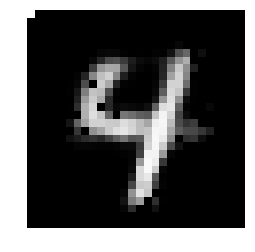

In [10]:
with tf.Session() as sess:
    saver.restore(sess, "./tmp/autoencoder.ckpt")
    g = sess.run(Decode, feed_dict={X: mnist.test.images[6].reshape(-1,28*28)})
    
    plt.clf()
    plt.imshow(g.reshape(28,28),cmap="gray")
    plt.axis("off")
    plt.show()
    